In [1]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from faker import Faker
from datetime import datetime, timedelta

In [3]:
# Initialize Faker and parameters
faker = Faker()
np.random.seed(42)

In [4]:
# Dataset size and time interval
n_hours = 744  # 31 days * 24 hours
start_date = datetime(2024, 1, 1, 0, 0)
timestamps = [start_date + timedelta(hours=i) for i in range(n_hours)]

In [5]:
# Generate synthetic weather data
temperature = np.random.normal(20, 5, n_hours)  # Average 20°C, std dev 5°C
wind_speed = np.random.uniform(2, 15, n_hours)  # Wind speed in m/s
solar_radiation = np.maximum(0, np.random.normal(500, 200, n_hours))  # Solar radiation (W/m²)
cloud_cover = np.random.uniform(0, 100, n_hours)  # Cloud cover percentage
precipitation = np.random.exponential(0.5, n_hours)  # Rain in mm

# Energy demand patterns
residential_demand = np.random.normal(300, 50, n_hours)  # kWh
commercial_demand = np.random.normal(500, 100, n_hours)  # kWh
industrial_demand = np.random.normal(1000, 200, n_hours)  # kWh

# Renewable energy generation
solar_energy_generated = solar_radiation * 0.2  # Efficiency factor
wind_energy_generated = wind_speed * 30  # Proportional factor

# Storage and grid
storage_capacity = 10000  # kWh (fixed)
current_storage = [0]  # Initialize storage level
energy_supplied_to_grid = []
energy_wasted = []


In [8]:
# Final refinement for strict energy conservation

# Re-initialize parameters
current_storage = [0]  # Initialize storage level
energy_supplied_to_grid = []
energy_wasted = []

for i in range(n_hours):
    total_generation = solar_energy_generated[i] + wind_energy_generated[i]
    total_demand = residential_demand[i] + commercial_demand[i] + industrial_demand[i]

    # Storage logic
    storage_available = storage_capacity - current_storage[-1]
    energy_to_store = min(total_generation, storage_available)
    new_storage_level = current_storage[-1] + energy_to_store

    # Energy to grid and wastage
    remaining_energy = total_generation - energy_to_store
    energy_to_grid = min(remaining_energy, total_demand)
    waste = max(0, remaining_energy - energy_to_grid)

    # Correct small numerical discrepancies
    total_utilized_energy = energy_to_store + energy_to_grid + waste
    discrepancy = total_generation - total_utilized_energy

    if abs(discrepancy) > 1e-5:  # Adjust to balance conservation
        waste += discrepancy

    # Append results
    current_storage.append(new_storage_level)
    energy_supplied_to_grid.append(energy_to_grid)
    energy_wasted.append(waste)

# Remove initial storage value
current_storage = current_storage[1:]

# Create DataFrame with final logic
data_final = {
    "Timestamp": timestamps,
    "Temperature (°C)": temperature,
    "Wind Speed (m/s)": wind_speed,
    "Solar Radiation (W/m²)": solar_radiation,
    "Cloud Cover (%)": cloud_cover,
    "Precipitation (mm)": precipitation,
    "Residential Demand (kWh)": residential_demand,
    "Commercial Demand (kWh)": commercial_demand,
    "Industrial Demand (kWh)": industrial_demand,
    "Solar Energy Generated (kWh)": solar_energy_generated,
    "Wind Energy Generated (kWh)": wind_energy_generated,
    "Current Storage Level (kWh)": current_storage,
    "Storage Capacity (kWh)": [storage_capacity] * n_hours,
    "Energy Supplied to Grid (kWh)": energy_supplied_to_grid,
    "Energy Wasted (kWh)": energy_wasted,
}

df_final = pd.DataFrame(data_final)

# Re-run validations
validations_final = {
    "Storage level within capacity": (df_final["Current Storage Level (kWh)"] <= storage_capacity).all(),
    "Non-negative energy waste": (df_final["Energy Wasted (kWh)"] >= 0).all(),
    "Non-negative grid supply": (df_final["Energy Supplied to Grid (kWh)"] >= 0).all(),
    "Energy conservation": np.isclose(
        df_final["Solar Energy Generated (kWh)"] + df_final["Wind Energy Generated (kWh)"],
        df_final["Current Storage Level (kWh)"]
        + df_final["Energy Supplied to Grid (kWh)"]
        + df_final["Energy Wasted (kWh)"],
        atol=1e-5
    ).all(),
}

df_final.head(), validations_final


(            Timestamp  Temperature (°C)  Wind Speed (m/s)  \
 0 2024-01-01 00:00:00         22.483571          4.161684   
 1 2024-01-01 01:00:00         19.308678         11.594437   
 2 2024-01-01 02:00:00         23.238443          3.076383   
 3 2024-01-01 03:00:00         27.615149          9.840977   
 4 2024-01-01 04:00:00         18.829233          5.189538   
 
    Solar Radiation (W/m²)  Cloud Cover (%)  Precipitation (mm)  \
 0              512.894883        63.271188            0.843537   
 1              104.906687        70.385709            0.752596   
 2              312.132921         0.436327            0.715335   
 3              471.182489        16.695309            0.103957   
 4              258.061051        71.304605            0.046269   
 
    Residential Demand (kWh)  Commercial Demand (kWh)  Industrial Demand (kWh)  \
 0                322.065358               331.081696              1058.189473   
 1                263.342190               452.873626     

In [9]:
df = pd.DataFrame(df_final)

In [10]:
df.to_csv('synthetic_data.csv', index=False)

In [11]:
df.head()

,Timestamp,Temperature (°C),Wind Speed (m/s),Solar Radiation (W/m²),Cloud Cover (%),Precipitation (mm),Residential Demand (kWh),Commercial Demand (kWh),Industrial Demand (kWh),Solar Energy Generated (kWh),Wind Energy Generated (kWh),Current Storage Level (kWh),Storage Capacity (kWh),Energy Supplied to Grid (kWh),Energy Wasted (kWh)
0,2024-01-01 00:00:00,22.483571,4.161684,512.894883,63.271188,0.843537,322.065358,331.081696,1058.189473,102.578977,124.850514,227.429490,10000,0.0,0
1,2024-01-01 01:00:00,19.308678,11.594437,104.906687,70.385709,0.752596,263.342190,452.873626,1191.567926,20.981337,347.833110,596.243938,10000,0.0,0
2,2024-01-01 02:00:00,23.238443,3.076383,312.132921,0.436327,0.715335,311.449820,302.451223,841.823642,62.426584,92.291480,750.962003,10000,0.0,0
3,2024-01-01 03:00:00,27.615149,9.840977,471.182489,16.695309,0.103957,207.104927,575.109945,1006.801619,94.236498,295.229323,1140.427823,10000,0.0,0
4,2024-01-01 04:00:00,18.829233,5.189538,258.061051,71.304605,0.046269,330.162375,293.491695,726.995641,51.612210,155.686153,1347.726186,10000,0.0,0


In [ ]:
df.tail()

,Timestamp,Temperature (°C),Wind Speed (m/s),Solar Radiation (W/m²),Cloud Cover (%),Precipitation (mm),Residential Demand (kWh),Commercial Demand (kWh),Industrial Demand (kWh),Solar Energy Generated (kWh),Wind Energy Generated (kWh),Current Storage Level (kWh),Storage Capacity (kWh),Energy Supplied to Grid (kWh),Energy Wasted (kWh)
739,2024-01-31 19:00:00,25.071850,3.757162,479.355649,69.464096,0.047088,195.895065,501.934407,899.960437,95.871130,112.714853,10000.0,10000,208.585983,0
740,2024-01-31 20:00:00,10.795629,14.520496,553.072470,21.871561,0.459287,327.657458,381.103658,966.029528,110.614494,435.614894,10000.0,10000,546.229387,0
741,2024-01-31 21:00:00,13.602115,9.143884,383.448268,59.530327,0.208484,272.589985,495.011985,1327.347992,76.689654,274.316519,10000.0,10000,351.006173,0
742,2024-01-31 22:00:00,16.875907,14.555688,12.236568,26.463503,1.246075,396.172290,395.387891,963.339858,2.447314,436.670643,10000.0,10000,439.117957,0
743,2024-01-31 23:00:00,20.130455,7.622472,473.144168,66.196894,0.260935,261.269251,547.340742,996.041131,94.628834,228.674173,10000.0,10000,323.303006,0


In [ ]:
total_generation = df["Solar Energy Generated (kWh)"] + df["Wind Energy Generated (kWh)"]
total_demand = df["Residential Demand (kWh)"] + df["Commercial Demand (kWh)"] + df["Industrial Demand (kWh)"]

In [ ]:
storage_available = df["Storage Capacity (kWh)"] - df["Current Storage Level (kWh)"]
energy_to_store = total_generation.clip(upper=storage_available)
new_storage_level = df["Current Storage Level (kWh)"] + energy_to_store

In [ ]:
df["Current Storage Level (kWh)"] = new_storage_level.clip(upper=df["Storage Capacity (kWh)"])

In [ ]:
df["Energy Supplied to Grid (kWh)"] = (total_generation - energy_to_store).clip(upper=total_demand)

In [ ]:
df["Energy Wasted (kWh)"] = (total_generation - energy_to_store - df["Energy Supplied to Grid (kWh)"]).clip(lower=0)

In [ ]:
df.head()

,Timestamp,Temperature (°C),Wind Speed (m/s),Solar Radiation (W/m²),Cloud Cover (%),Precipitation (mm),Residential Demand (kWh),Commercial Demand (kWh),Industrial Demand (kWh),Solar Energy Generated (kWh),Wind Energy Generated (kWh),Current Storage Level (kWh),Storage Capacity (kWh),Energy Supplied to Grid (kWh),Energy Wasted (kWh)
0,2024-01-01 00:00:00,22.483571,4.161684,512.894883,63.271188,0.843537,322.065358,331.081696,1058.189473,102.578977,124.850514,454.858981,10000,0.0,0.0
1,2024-01-01 01:00:00,19.308678,11.594437,104.906687,70.385709,0.752596,263.342190,452.873626,1191.567926,20.981337,347.833110,965.058386,10000,0.0,0.0
2,2024-01-01 02:00:00,23.238443,3.076383,312.132921,0.436327,0.715335,311.449820,302.451223,841.823642,62.426584,92.291480,905.680068,10000,0.0,0.0
3,2024-01-01 03:00:00,27.615149,9.840977,471.182489,16.695309,0.103957,207.104927,575.109945,1006.801619,94.236498,295.229323,1529.893644,10000,0.0,0.0
4,2024-01-01 04:00:00,18.829233,5.189538,258.061051,71.304605,0.046269,330.162375,293.491695,726.995641,51.612210,155.686153,1555.024549,10000,0.0,0.0


In [ ]:
# Step 3: Identify redundant or unnecessary columns
correlation_matrix = df.corr()
redundant_columns = [
    col
    for col in df.columns
    if df[col].nunique() == 1 or col in ["Storage Capacity (kWh)"]  # Static column
]

In [ ]:

redundant_columns

['Storage Capacity (kWh)', 'Energy Wasted (kWh)']

In [ ]:
df.head(10)

,Timestamp,Temperature (°C),Wind Speed (m/s),Solar Radiation (W/m²),Cloud Cover (%),Precipitation (mm),Residential Demand (kWh),Commercial Demand (kWh),Industrial Demand (kWh),Solar Energy Generated (kWh),Wind Energy Generated (kWh),Current Storage Level (kWh),Storage Capacity (kWh),Energy Supplied to Grid (kWh),Energy Wasted (kWh)
0,2024-01-01 00:00:00,22.483571,4.161684,512.894883,63.271188,0.843537,322.065358,331.081696,1058.189473,102.578977,124.850514,454.858981,10000,0.0,0.0
1,2024-01-01 01:00:00,19.308678,11.594437,104.906687,70.385709,0.752596,263.342190,452.873626,1191.567926,20.981337,347.833110,965.058386,10000,0.0,0.0
2,2024-01-01 02:00:00,23.238443,3.076383,312.132921,0.436327,0.715335,311.449820,302.451223,841.823642,62.426584,92.291480,905.680068,10000,0.0,0.0
3,2024-01-01 03:00:00,27.615149,9.840977,471.182489,16.695309,0.103957,207.104927,575.109945,1006.801619,94.236498,295.229323,1529.893644,10000,0.0,0.0
4,2024-01-01 04:00:00,18.829233,5.189538,258.061051,71.304605,0.046269,330.162375,293.491695,726.995641,51.612210,155.686153,1555.024549,10000,0.0,0.0
5,2024-01-01 05:00:00,18.829315,7.060843,619.985746,66.638541,0.600238,314.907923,502.845758,1140.298956,123.997149,211.825289,2019.371064,10000,0.0,0.0
6,2024-01-01 06:00:00,27.896064,5.753019,806.150166,96.604751,0.229708,331.933008,292.218818,1103.774236,161.230033,172.590557,2351.189806,10000,0.0,0.0
7,2024-01-01 07:00:00,23.837174,6.623745,743.752370,76.103779,0.283122,352.905916,467.970220,1099.161004,148.750474,198.712359,2712.294883,10000,0.0,0.0
8,2024-01-01 08:00:00,17.652628,11.347597,457.311426,95.077271,0.015822,318.380992,664.337816,1000.323806,91.462285,340.427903,3228.612426,10000,0.0,0.0
9,2024-01-01 09:00:00,22.712800,5.862582,798.145227,70.254050,0.150266,307.404471,536.064789,1082.954578,159.629045,175.877469,3467.735267,10000,0.0,0.0


In [ ]:
df.dtypes

,0
Timestamp,datetime64[ns]
Temperature (°C),float64
Wind Speed (m/s),float64
Solar Radiation (W/m²),float64
Cloud Cover (%),float64
Precipitation (mm),float64
Residential Demand (kWh),float64
Commercial Demand (kWh),float64
Industrial Demand (kWh),float64
Solar Energy Generated (kWh),float64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Timestamp                      744 non-null    datetime64[ns]
 1   Temperature (°C)               744 non-null    float64       
 2   Wind Speed (m/s)               744 non-null    float64       
 3   Solar Radiation (W/m²)         744 non-null    float64       
 4   Cloud Cover (%)                744 non-null    float64       
 5   Precipitation (mm)             744 non-null    float64       
 6   Residential Demand (kWh)       744 non-null    float64       
 7   Commercial Demand (kWh)        744 non-null    float64       
 8   Industrial Demand (kWh)        744 non-null    float64       
 9   Solar Energy Generated (kWh)   744 non-null    float64       
 10  Wind Energy Generated (kWh)    744 non-null    float64       
 11  Current Storage Lev

In [ ]:
df.describe()

,Timestamp,Temperature (°C),Wind Speed (m/s),Solar Radiation (W/m²),Cloud Cover (%),Precipitation (mm),Residential Demand (kWh),Commercial Demand (kWh),Industrial Demand (kWh),Solar Energy Generated (kWh),Wind Energy Generated (kWh),Current Storage Level (kWh),Storage Capacity (kWh),Energy Supplied to Grid (kWh),Energy Wasted (kWh)
count,744,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.0,744.000000,744.0
mean,2024-01-16 11:29:59.999999744,19.928626,8.631938,507.829744,49.608242,0.498150,300.423303,493.407720,993.671798,101.565949,258.958126,9811.272513,10000.0,347.539951,0.0
min,2024-01-01 00:00:00,3.793663,2.064220,0.000000,0.001163,0.000327,153.527565,182.957426,364.659237,0.000000,61.926593,454.858981,10000.0,0.000000,0.0
25%,2024-01-08 17:45:00,16.498463,5.183471,377.464261,24.956361,0.135891,263.537292,432.121004,862.641994,75.492852,155.504138,10000.000000,10000.0,252.597582,0.0
50%,2024-01-16 11:30:00,20.025893,8.799789,502.111046,50.050236,0.331095,301.221263,496.743564,993.943656,100.422209,263.993665,10000.000000,10000.0,355.422661,0.0
75%,2024-01-24 05:15:00,23.143332,11.897449,641.647356,73.789309,0.702406,333.252479,562.420876,1126.666520,128.329471,356.923462,10000.000000,10000.0,457.032220,0.0
max,2024-01-31 23:00:00,39.263657,14.992378,1138.621514,99.718235,3.861765,462.154648,781.465444,1622.582040,227.724303,449.771353,10000.000000,10000.0,672.099779,0.0
std,NaN,4.927000,3.806877,197.842226,28.687301,0.516030,51.014713,98.788404,196.615658,39.568445,114.206324,1087.107870,0.0,136.476287,0.0


In [ ]:
df.isnull().sum()

,0
Timestamp,0
Temperature (°C),0
Wind Speed (m/s),0
Solar Radiation (W/m²),0
Cloud Cover (%),0
Precipitation (mm),0
Residential Demand (kWh),0
Commercial Demand (kWh),0
Industrial Demand (kWh),0
Solar Energy Generated (kWh),0


In [ ]:
df.shape

(744, 15)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

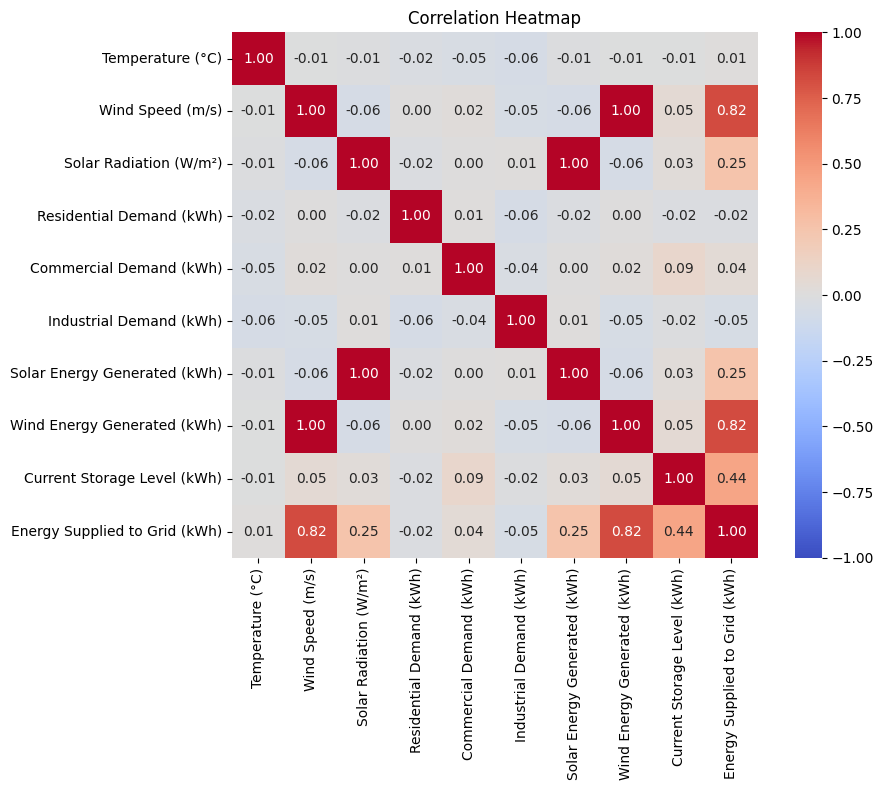

In [ ]:
numerical_cols = [
    "Temperature (°C)",
    "Wind Speed (m/s)",
    "Solar Radiation (W/m²)",
    "Residential Demand (kWh)",
    "Commercial Demand (kWh)",
    "Industrial Demand (kWh)",
    "Solar Energy Generated (kWh)",
    "Wind Energy Generated (kWh)",
    "Current Storage Level (kWh)",
    "Energy Supplied to Grid (kWh)"
]

# Calculate the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


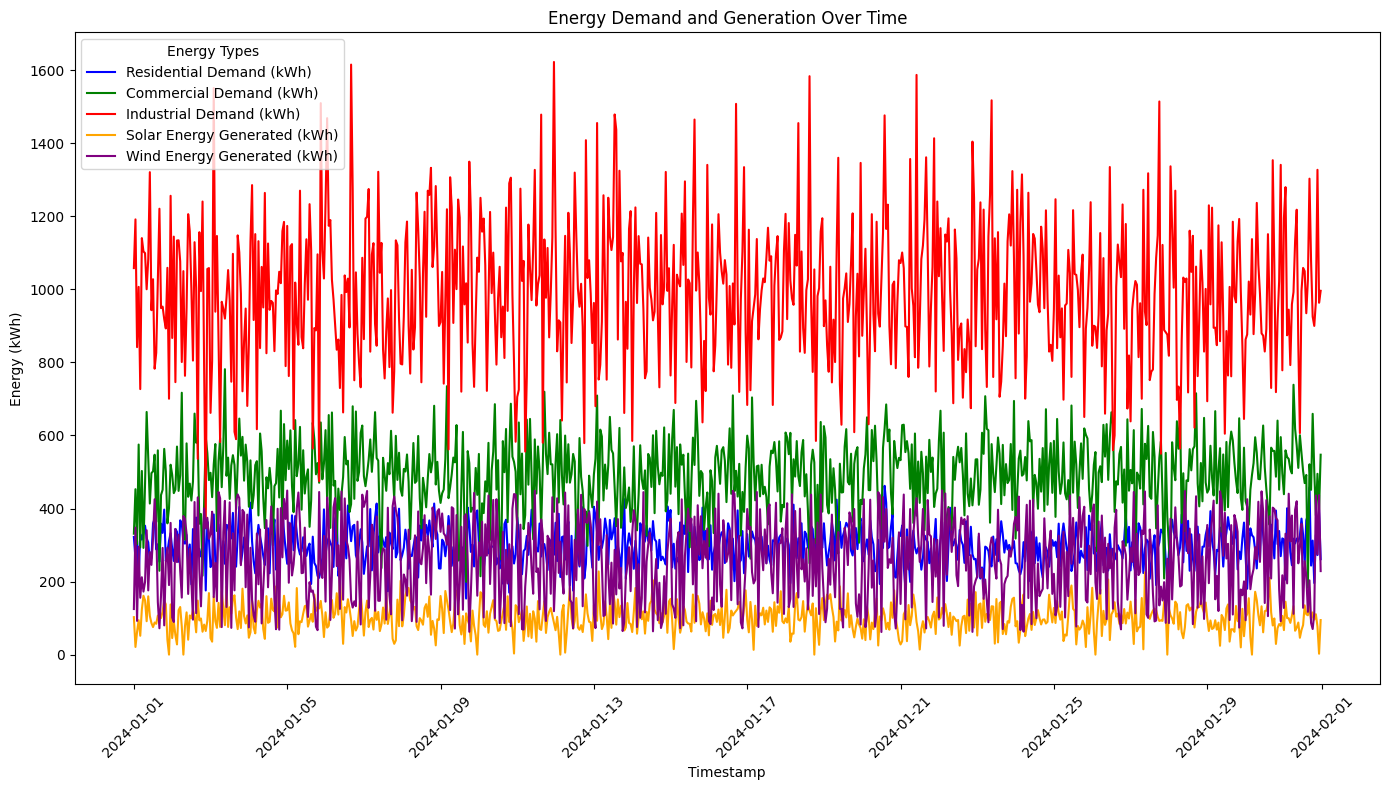

In [ ]:

df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set the figure size
plt.figure(figsize=(14, 8))

# Plotting each variable over time
sns.lineplot(data=df, x='Timestamp', y='Residential Demand (kWh)', label='Residential Demand (kWh)', color='blue')
sns.lineplot(data=df, x='Timestamp', y='Commercial Demand (kWh)', label='Commercial Demand (kWh)', color='green')
sns.lineplot(data=df, x='Timestamp', y='Industrial Demand (kWh)', label='Industrial Demand (kWh)', color='red')
sns.lineplot(data=df, x='Timestamp', y='Solar Energy Generated (kWh)', label='Solar Energy Generated (kWh)', color='orange')
sns.lineplot(data=df, x='Timestamp', y='Wind Energy Generated (kWh)', label='Wind Energy Generated (kWh)', color='purple')

# Adding titles and labels
plt.title('Energy Demand and Generation Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Energy (kWh)')
plt.legend(title='Energy Types')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


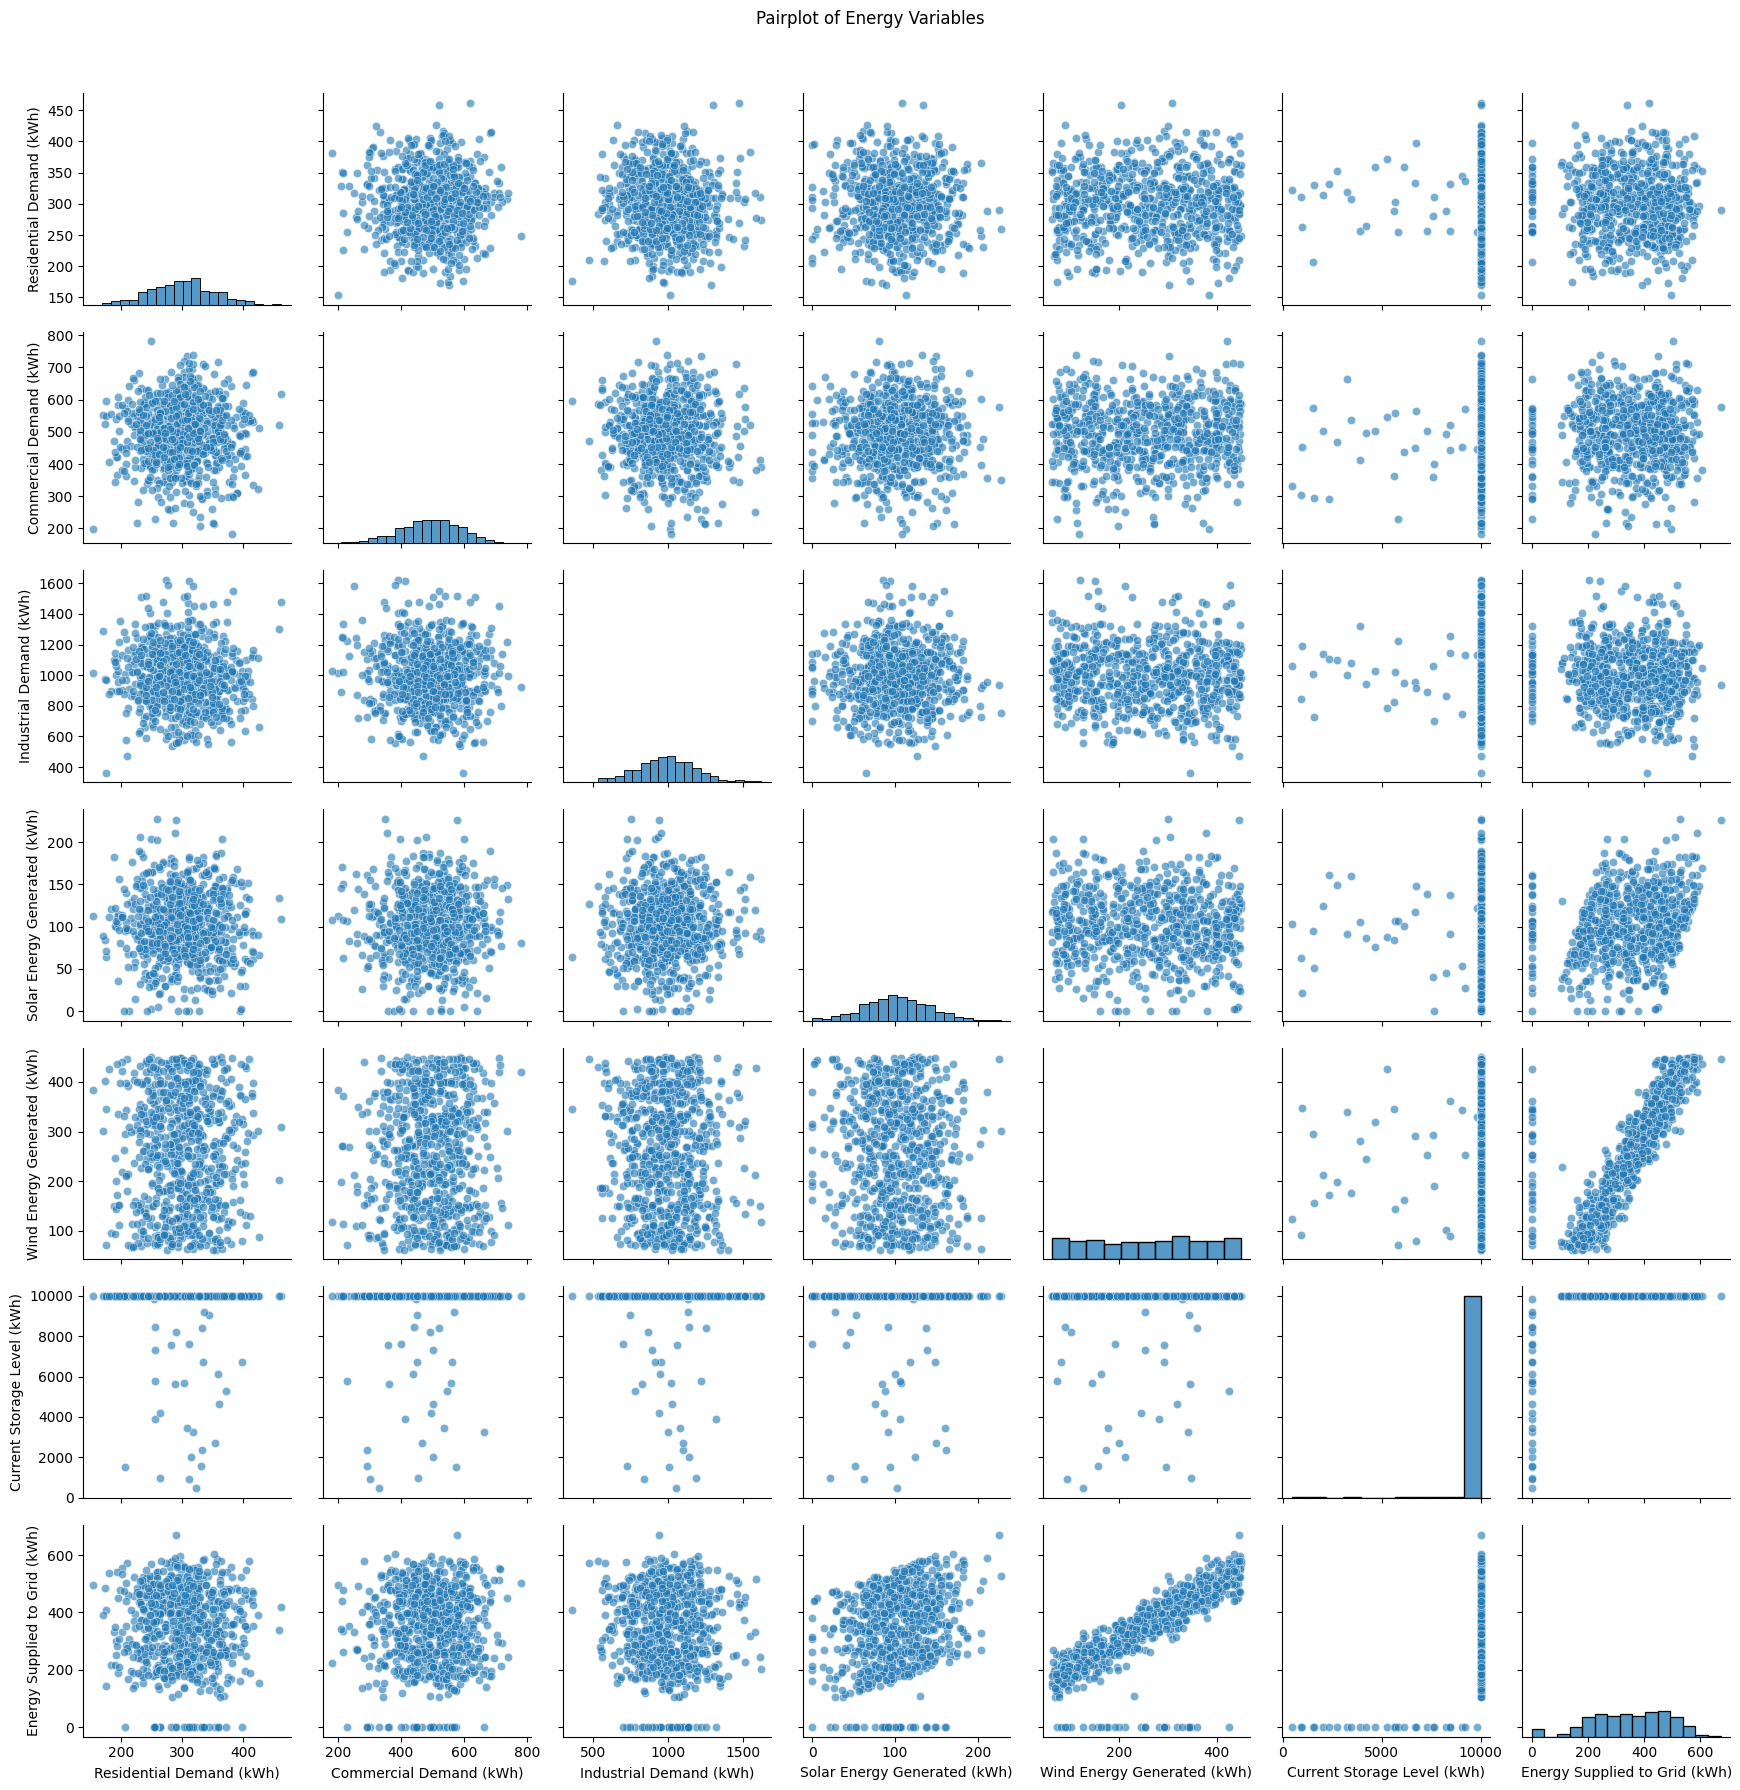

In [ ]:

# List of numerical columns to include in the pairplot
numerical_cols = [
    "Residential Demand (kWh)",
    "Commercial Demand (kWh)",
    "Industrial Demand (kWh)",
    "Solar Energy Generated (kWh)",
    "Wind Energy Generated (kWh)",
    "Current Storage Level (kWh)",
    "Energy Supplied to Grid (kWh)"
]

# Create a pairplot for the selected numerical columns
sns.pairplot(df[numerical_cols], kind='scatter', plot_kws={'alpha': 0.6})

# Add title to the plot
plt.suptitle('Pairplot of Energy Variables', y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
df['hour'] = pd.to_datetime(df['Timestamp']).dt.hour
df['weekday'] = pd.to_datetime(df['Timestamp']).dt.weekday
df['month'] = pd.to_datetime(df['Timestamp']).dt.month

In [ ]:
df['solar_lag_1'] = df['Solar Energy Generated (kWh)'].shift(1)
df['wind_lag_1'] = df['Wind Energy Generated (kWh)'].shift(1)

In [ ]:
df.head()

,Timestamp,Temperature (°C),Wind Speed (m/s),Solar Radiation (W/m²),Cloud Cover (%),Precipitation (mm),Residential Demand (kWh),Commercial Demand (kWh),Industrial Demand (kWh),Solar Energy Generated (kWh),Wind Energy Generated (kWh),Current Storage Level (kWh),Storage Capacity (kWh),Energy Supplied to Grid (kWh),Energy Wasted (kWh),hour,weekday,month,solar_lag_1,wind_lag_1
0,2024-01-01 00:00:00,22.483571,4.161684,512.894883,63.271188,0.843537,322.065358,331.081696,1058.189473,102.578977,124.850514,454.858981,10000,0.0,0.0,0,0,1,NaN,NaN
1,2024-01-01 01:00:00,19.308678,11.594437,104.906687,70.385709,0.752596,263.342190,452.873626,1191.567926,20.981337,347.833110,965.058386,10000,0.0,0.0,1,0,1,102.578977,124.850514
2,2024-01-01 02:00:00,23.238443,3.076383,312.132921,0.436327,0.715335,311.449820,302.451223,841.823642,62.426584,92.291480,905.680068,10000,0.0,0.0,2,0,1,20.981337,347.833110
3,2024-01-01 03:00:00,27.615149,9.840977,471.182489,16.695309,0.103957,207.104927,575.109945,1006.801619,94.236498,295.229323,1529.893644,10000,0.0,0.0,3,0,1,62.426584,92.291480
4,2024-01-01 04:00:00,18.829233,5.189538,258.061051,71.304605,0.046269,330.162375,293.491695,726.995641,51.612210,155.686153,1555.024549,10000,0.0,0.0,4,0,1,94.236498,295.229323


In [ ]:
df.drop(index=0, inplace=True)

In [ ]:
df.isnull().sum()

,0
Timestamp,0
Temperature (°C),0
Wind Speed (m/s),0
Solar Radiation (W/m²),0
Cloud Cover (%),0
Precipitation (mm),0
Residential Demand (kWh),0
Commercial Demand (kWh),0
Industrial Demand (kWh),0
Solar Energy Generated (kWh),0


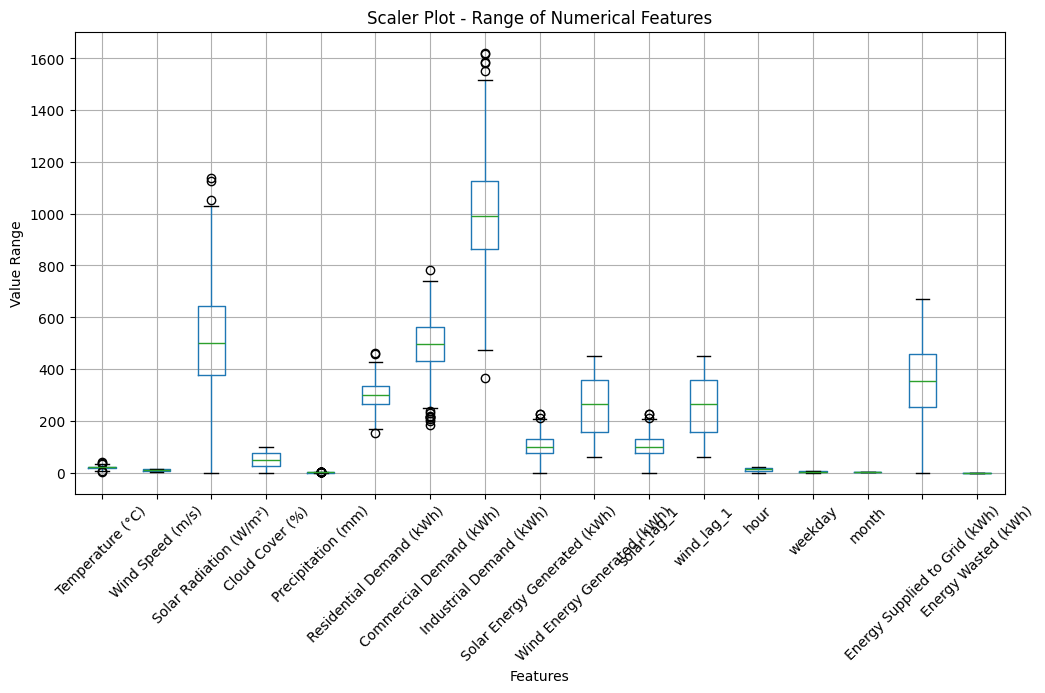

In [ ]:
import matplotlib.pyplot as plt

# Select numerical columns
numerical_columns = ['Temperature (°C)', 'Wind Speed (m/s)', 'Solar Radiation (W/m²)', 'Cloud Cover (%)',
                     'Precipitation (mm)', 'Residential Demand (kWh)', 'Commercial Demand (kWh)',
                     'Industrial Demand (kWh)', 'Solar Energy Generated (kWh)', 'Wind Energy Generated (kWh)',
                     'solar_lag_1', 'wind_lag_1', 'hour', 'weekday', 'month','Energy Supplied to Grid (kWh)', 'Energy Wasted (kWh)' ]

# Plot a boxplot for visualization
plt.figure(figsize=(12, 6))
df[numerical_columns].boxplot(rot=45)
plt.title("Scaler Plot - Range of Numerical Features")
plt.ylabel("Value Range")
plt.xlabel("Features")
plt.show()


In [ ]:
# Step 1: Calculate total energy generated
df["Total Energy Generated (kWh)"] = df["Solar Energy Generated (kWh)"] + df["Wind Energy Generated (kWh)"]

# Step 2: Calculate energy stored (change in storage level)
df["Energy Stored (kWh)"] = df["Current Storage Level (kWh)"] - df["Current Storage Level (kWh)"].shift(1, fill_value=0)

# Step 3: Verify energy conservation
df["Energy Balance"] = (
    df["Total Energy Generated (kWh)"]
    - df["Energy Stored (kWh)"]
    - df["Energy Supplied to Grid (kWh)"]
    - df["Energy Wasted (kWh)"]
)

# Step 4: Check if energy balance is approximately zero
tolerance = 1e-3  # Small value for floating-point tolerance
energy_conservation_violations = np.abs(df["Energy Balance"]) > tolerance

if energy_conservation_violations.any():
    print("Energy conservation violated in the following rows:")
    print(df.loc[energy_conservation_violations, ["Total Energy Generated (kWh)", "Energy Stored (kWh)", "Energy Balance"]])
else:
    print("Energy conservation holds for all rows.")
    print(df[["Total Energy Generated (kWh)", "Energy Stored (kWh)", "Energy Balance"]])

Energy conservation violated in the following rows:
    Total Energy Generated (kWh)  Energy Stored (kWh)  Energy Balance
1                     368.814448           965.058386     -596.243938
2                     154.718065           -59.378318      214.096383
3                     389.465820           624.213576     -234.747756
4                     207.298363            25.130906      182.167457
5                     335.822439           464.346514     -128.524076
6                     333.820591           331.818743        2.001848
7                     347.462833           361.105076      -13.642243
8                     431.890188           516.317543      -84.427355
9                     335.506515           239.122841       96.383674
10                    386.844508           438.182501      -51.337993
11                    332.176218           277.507928       54.668290
12                    394.295648           456.415078      -62.119430
13                    513.264811      

In [ ]:
# Check for rows AFTER the 30th energy conservation violation
print("Checking rows after the 30th Energy Conservation Violation:")

# Find the index of the 30th violation
thirty_violation_index = df.loc[energy_conservation_violations].index[29]  # Index of the 30th row

# Filter rows AFTER the 30th violation
rows_after_30th_violation = df.loc[thirty_violation_index + 1:, ["Total Energy Generated (kWh)",
                                                                "Energy Stored (kWh)",
                                                                "Energy Balance"]]

# Display the first 5 rows after the 30th violation
print("\nFirst 5 rows after the 30th violation:")
print(rows_after_30th_violation.head())

# Check if 'Energy Balance' is zero for these rows
energy_balance_non_zero = rows_after_30th_violation[rows_after_30th_violation["Energy Balance"] != 0]

if not energy_balance_non_zero.empty:
    print("\nRows after 30th violation where Energy Balance is NOT zero:")
    print(energy_balance_non_zero)
else:
    print("\nAll rows after the 30th violation have Energy Balance = 0.")


Checking rows after the 30th Energy Conservation Violation:

First 5 rows after the 30th violation:
    Total Energy Generated (kWh)  Energy Stored (kWh)  Energy Balance
31                    379.449904                  0.0             0.0
32                    449.922415                  0.0             0.0
33                    446.603784                  0.0             0.0
34                    206.980141                  0.0             0.0
35                    397.524357                  0.0             0.0

All rows after the 30th violation have Energy Balance = 0.


In [ ]:
# Identify rows where Energy Balance is not zero
violating_rows = df["Energy Balance"] != 0

# Drop the violating rows
df_cleaned = df.loc[~violating_rows].reset_index(drop=True)

# Display results
print(f"Number of rows removed: {violating_rows.sum()}")
print(f"Remaining rows after cleaning: {df_cleaned.shape[0]}")

# Check the first few rows of the cleaned data
print("\nFirst 5 rows of the cleaned data:")
print(df_cleaned.head())

Number of rows removed: 30
Remaining rows after cleaning: 713

First 5 rows of the cleaned data:
            Timestamp  Temperature (°C)  Wind Speed (m/s)  \
0 2024-01-02 07:00:00         29.261391         12.648330   
1 2024-01-02 08:00:00         19.932514         12.392406   
2 2024-01-02 09:00:00         14.711445         11.031054   
3 2024-01-02 10:00:00         24.112725          5.537887   
4 2024-01-02 11:00:00         13.895782          9.672999   

   Solar Radiation (W/m²)  Cloud Cover (%)  Precipitation (mm)  \
0                0.000000        88.015674            0.821666   
1              390.751110        21.574068            0.976046   
2              578.360801        67.781320            3.022074   
3              204.217686        60.775212            0.138204   
4              536.671984        29.530148            0.020594   

   Residential Demand (kWh)  Commercial Demand (kWh)  Industrial Demand (kWh)  \
0                306.714825               357.631736      

In [ ]:
df = pd.DataFrame(df_cleaned)

In [ ]:
df.shape

(713, 23)

In [ ]:
df_cleaned.head()

,Timestamp,Temperature (°C),Wind Speed (m/s),Solar Radiation (W/m²),Cloud Cover (%),Precipitation (mm),Residential Demand (kWh),Commercial Demand (kWh),Industrial Demand (kWh),Solar Energy Generated (kWh),...,Energy Supplied to Grid (kWh),Energy Wasted (kWh),hour,weekday,month,solar_lag_1,wind_lag_1,Total Energy Generated (kWh),Energy Stored (kWh),Energy Balance
0,2024-01-02 07:00:00,29.261391,12.648330,0.000000,88.015674,0.821666,306.714825,357.631736,1049.909638,0.000000,...,379.449904,0.0,7,1,1,76.939584,156.096793,379.449904,0.0,0.0
1,2024-01-02 08:00:00,19.932514,12.392406,390.751110,21.574068,0.976046,303.979893,314.815727,763.388763,78.150222,...,449.922415,0.0,8,1,1,0.000000,379.449904,449.922415,0.0,0.0
2,2024-01-02 09:00:00,14.711445,11.031054,578.360801,67.781320,3.022074,327.702889,578.358966,949.447349,115.672160,...,446.603784,0.0,9,1,1,78.150222,371.772193,446.603784,0.0,0.0
3,2024-01-02 10:00:00,24.112725,5.537887,204.217686,60.775212,0.138204,256.914846,432.135694,1205.882620,40.843537,...,206.980141,0.0,10,1,1,115.672160,330.931624,206.980141,0.0,0.0
4,2024-01-02 11:00:00,13.895782,9.672999,536.671984,29.530148,0.020594,301.501574,468.176247,1159.340385,107.334397,...,397.524357,0.0,11,1,1,40.843537,166.136604,397.524357,0.0,0.0


In [ ]:
df.head()

,Timestamp,Temperature (°C),Wind Speed (m/s),Solar Radiation (W/m²),Cloud Cover (%),Precipitation (mm),Residential Demand (kWh),Commercial Demand (kWh),Industrial Demand (kWh),Solar Energy Generated (kWh),...,Energy Supplied to Grid (kWh),Energy Wasted (kWh),hour,weekday,month,solar_lag_1,wind_lag_1,Total Energy Generated (kWh),Energy Stored (kWh),Energy Balance
0,2024-01-02 07:00:00,29.261391,12.648330,0.000000,88.015674,0.821666,306.714825,357.631736,1049.909638,0.000000,...,379.449904,0.0,7,1,1,76.939584,156.096793,379.449904,0.0,0.0
1,2024-01-02 08:00:00,19.932514,12.392406,390.751110,21.574068,0.976046,303.979893,314.815727,763.388763,78.150222,...,449.922415,0.0,8,1,1,0.000000,379.449904,449.922415,0.0,0.0
2,2024-01-02 09:00:00,14.711445,11.031054,578.360801,67.781320,3.022074,327.702889,578.358966,949.447349,115.672160,...,446.603784,0.0,9,1,1,78.150222,371.772193,446.603784,0.0,0.0
3,2024-01-02 10:00:00,24.112725,5.537887,204.217686,60.775212,0.138204,256.914846,432.135694,1205.882620,40.843537,...,206.980141,0.0,10,1,1,115.672160,330.931624,206.980141,0.0,0.0
4,2024-01-02 11:00:00,13.895782,9.672999,536.671984,29.530148,0.020594,301.501574,468.176247,1159.340385,107.334397,...,397.524357,0.0,11,1,1,40.843537,166.136604,397.524357,0.0,0.0


In [ ]:
df = df.drop(columns=["Energy Balance"])

In [ ]:
df.tail()

,Timestamp,Temperature (°C),Wind Speed (m/s),Solar Radiation (W/m²),Cloud Cover (%),Precipitation (mm),Residential Demand (kWh),Commercial Demand (kWh),Industrial Demand (kWh),Solar Energy Generated (kWh),...,Storage Capacity (kWh),Energy Supplied to Grid (kWh),Energy Wasted (kWh),hour,weekday,month,solar_lag_1,wind_lag_1,Total Energy Generated (kWh),Energy Stored (kWh)
708,2024-01-31 19:00:00,25.071850,3.757162,479.355649,69.464096,0.047088,195.895065,501.934407,899.960437,95.871130,...,10000,208.585983,0.0,19,2,1,115.618594,70.066644,208.585983,0.0
709,2024-01-31 20:00:00,10.795629,14.520496,553.072470,21.871561,0.459287,327.657458,381.103658,966.029528,110.614494,...,10000,546.229387,0.0,20,2,1,95.871130,112.714853,546.229387,0.0
710,2024-01-31 21:00:00,13.602115,9.143884,383.448268,59.530327,0.208484,272.589985,495.011985,1327.347992,76.689654,...,10000,351.006173,0.0,21,2,1,110.614494,435.614894,351.006173,0.0
711,2024-01-31 22:00:00,16.875907,14.555688,12.236568,26.463503,1.246075,396.172290,395.387891,963.339858,2.447314,...,10000,439.117957,0.0,22,2,1,76.689654,274.316519,439.117957,0.0
712,2024-01-31 23:00:00,20.130455,7.622472,473.144168,66.196894,0.260935,261.269251,547.340742,996.041131,94.628834,...,10000,323.303006,0.0,23,2,1,2.447314,436.670643,323.303006,0.0


In [ ]:
from sklearn.preprocessing import StandardScaler

# Select numerical columns to scale (excluding target and categorical columns)
numerical_columns = ['Temperature (°C)', 'Wind Speed (m/s)', 'Solar Radiation (W/m²)', 'Cloud Cover (%)',
                     'Precipitation (mm)', 'Residential Demand (kWh)', 'Commercial Demand (kWh)',
                     'Industrial Demand (kWh)', 'Solar Energy Generated (kWh)', 'Wind Energy Generated (kWh)',
                     'solar_lag_1', 'wind_lag_1', 'hour', 'weekday', 'month']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [ ]:
# Define the target column
target_column = 'Energy Supplied to Grid (kWh)'

# Separate features (X) and target (y)
X = df.drop(columns=[target_column, 'Timestamp'])  # Drop Timestamp and target column
y = df[target_column]


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Initialize the XGBoost Regressor
model = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                         max_depth=5, alpha=10, n_estimators=10)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 73.81273976663425


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Reshape data for LSTM (samples, time steps, features)
X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

# Initialize LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))  # Predicting a single value (energy supplied to grid)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32)

# Make predictions
y_pred_lstm = model.predict(X_test_reshaped)

# Evaluate the model (RMSE)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = mse_lstm**0.5
print(f"Root Mean Squared Error (LSTM): {rmse_lstm}")


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 146432.3438
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 147828.9844  
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 145281.7969
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 142867.4219
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 144535.0156
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 140818.4531 
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 142795.5781
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 140953.0312 
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 136210.9219
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 135012.3750 
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 139513.4844
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 134244.4062
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 134470.3750
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 133445.7188
Epoch 15/50
18/18 ━━━

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate additional metrics (for XGBoost or LSTM)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")


Mean Absolute Error (MAE): 63.537414622363244
R-squared: 0.5995329451483624


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

# Define the model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [3, 5, 7],          # Maximum depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.8, 1.0],         # Fraction of samples used for fitting individual trees
    'colsample_bytree': [0.8, 1.0],  # Fraction of features used for fitting individual trees
    'reg_alpha': [0, 0.1, 1],        # L1 regularization
    'reg_lambda': [1, 10],           # L2 regularization
}

# Define scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgboost_model, param_grid=param_grid, scoring=scorer, cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Train model with best parameters
best_xgboost_model = grid_search.best_estimator_

# Evaluate the model
y_pred = best_xgboost_model.predict(X_test)

# Calculate metrics
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Optimized XGBoost RMSE: {rmse}")


Fitting 3 folds for each of 648 candidates, totalling 1944 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 1.0}
Optimized XGBoost RMSE: 6.765960709639642


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Retrieve the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Predict the test data using the best model
y_pred = best_model.predict(X_test)

# Calculate R² Score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)

print(f"R² Score for the Optimized XGBoost Model: {r2}")


R² Score for the Optimized XGBoost Model: 0.9966351703250506


In [ ]:
import pandas as pd

# Define rough sample values for prediction
sample_data = {
    'Temperature (°C)': [8.5],
    'Wind Speed (m/s)': [10.2],
    'Solar Radiation (W/m²)': [45.0],
    'Cloud Cover (%)': [60.0],
    'Precipitation (mm)': [0.0],
    'Residential Demand (kWh)': [300.0],
    'Commercial Demand (kWh)': [400.0],
    'Industrial Demand (kWh)': [1200.0],
    'Solar Energy Generated (kWh)': [40.0],
    'Wind Energy Generated (kWh)': [100.0],
    'Current Storage Level (kWh)': [80.0],
    'hour': [13],
    'weekday': [1],
    'month': [7],
    'solar_lag_1': [45],
    'wind_lag_1': [100.0]
}

# Convert to a DataFrame
input_data = pd.DataFrame(sample_data)

# Load the trained model (ensure the model is saved or accessible in this environment)
# For example: import joblib; model = joblib.load("xgboost_model.pkl")

# Make prediction
predicted_value = best_model.predict(input_data)

# Output the prediction
print(f"Predicted Energy Supplied to Grid (kWh) (2): {predicted_value[0]}")


In [ ]:
importance = best_model.feature_importances_
for feature, score in zip(input_data.columns, importance):
    print(f"{feature}: {score}")


In [ ]:
import pandas as pd

# Define new rough sample values for prediction (changed from previous ones)
sample_data = {
    'Temperature (°C)': [15.3],                # Example: 15.3°C
    'Wind Speed (m/s)': [7.5],                 # Example: 7.5 m/s
    'Solar Radiation (W/m²)': [300.0],         # Example: 300 W/m²
    'Cloud Cover (%)': [50.0],                 # Example: 50% cloud cover
    'Precipitation (mm)': [5.0],               # Example: 5 mm of precipitation
    'Residential Demand (kWh)': [250.0],       # Example: 250 kWh residential demand
    'Commercial Demand (kWh)': [500.0],        # Example: 500 kWh commercial demand
    'Industrial Demand (kWh)': [1000.0],       # Example: 1000 kWh industrial demand
    'Solar Energy Generated (kWh)': [120.0],   # Example: 120 kWh solar energy generated
    'Wind Energy Generated (kWh)': [200.0],    # Example: 200 kWh wind energy generated
    'Current Storage Level (kWh)': [100.0],    # Example: 100 kWh current storage
    'hour': [9],                               # Example: 9 AM
    'weekday': [3],                            # Example: Wednesday
    'month': [3],                              # Example: March
    'solar_lag_1': [100.0],                    # Example: 100 kWh from previous solar generation
    'wind_lag_1': [150.0]                      # Example: 150 kWh from previous wind generation
}

# Convert to a DataFrame
input_data = pd.DataFrame(sample_data)

# Load the trained model (ensure the model is saved or accessible in this environment)
# For example: import joblib; model = joblib.load("xgboost_model.pkl")

# Make prediction
predicted_value = best_model.predict(input_data)

# Output the prediction
print(f"Predicted Energy Supplied to Grid (kWh): {predicted_value[0]}")


In [ ]:
sample_data = {
    'Temperature (°C)': [25.7],
    'Wind Speed (m/s)': [10.2],
    'Solar Radiation (W/m²)': [600.0],
    'Cloud Cover (%)': [20.0],
    'Precipitation (mm)': [0.0],
    'Residential Demand (kWh)': [300.0],
    'Commercial Demand (kWh)': [600.0],
    'Industrial Demand (kWh)': [1200.0],
    'Solar Energy Generated (kWh)': [200.0],
    'Wind Energy Generated (kWh)': [300.0],
    'Current Storage Level (kWh)': [500.0],
    'hour': [9],
    'weekday': [5],
    'month': [6],
    'solar_lag_1': [180.0],
    'wind_lag_1': [280.0]
}
input_data = pd.DataFrame(sample_data)
predicted_value = best_model.predict(input_data)
print(f"Predicted Energy Supplied to Grid (kWh): {predicted_value[0]}")

In [ ]:
sample_data = {
    'Temperature (°C)': [10.5],
    'Wind Speed (m/s)': [5.8],
    'Solar Radiation (W/m²)': [150.0],
    'Cloud Cover (%)': [70.0],
    'Precipitation (mm)': [2.0],
    'Residential Demand (kWh)': [220.0],
    'Commercial Demand (kWh)': [450.0],
    'Industrial Demand (kWh)': [950.0],
    'Solar Energy Generated (kWh)': [80.0],
    'Wind Energy Generated (kWh)': [180.0],
    'Current Storage Level (kWh)': [50.0],
    'hour': [22],
    'weekday': [1],
    'month': [11],
    'solar_lag_1': [60.0],
    'wind_lag_1': [170.0]
}
input_data = pd.DataFrame(sample_data)
predicted_value = best_model.predict(input_data)
print(f"Predicted Energy Supplied to Grid (kWh): {predicted_value[0]}")

End to End project cycle

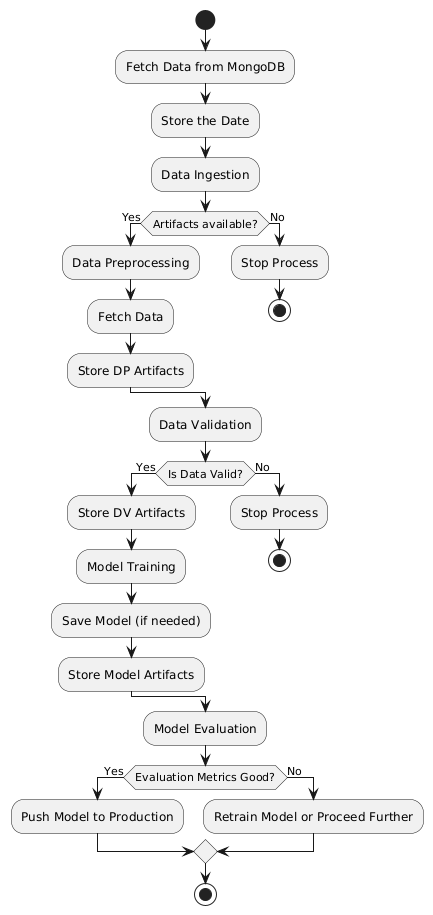


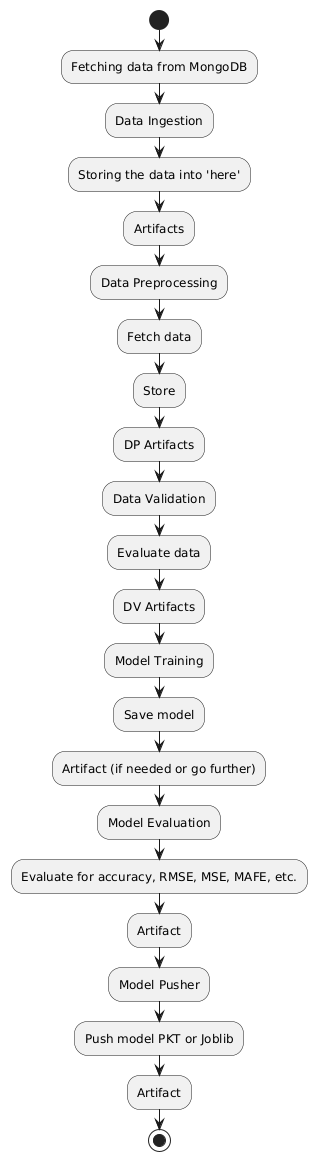

Steps :

1. Created synthetic data and store it in synthetic_data.csv
2. (1) Check data then create Energy supplied grid by calculations
  (2) found unnecessary columns and drop them ['Storage Capacity (kWh)', 'Energy Wasted (kWh)']

3. Then looked for description, missing values
4. Defined numerical cols like this
numerical_cols = [
    "Temperature (°C)",
    "Wind Speed (m/s)",
    "Solar Radiation (W/m²)",
    "Residential Demand (kWh)",
    "Commercial Demand (kWh)",
    "Industrial Demand (kWh)",
    "Solar Energy Generated (kWh)",
    "Wind Energy Generated (kWh)",
    "Current Storage Level (kWh)",
    "Energy Supplied to Grid (kWh)"
]

and performed eda

5. created features (columns) = hour, weekday, month from timestamp and wind_lag_1 and solar_lag_1 from wind energy generated & solar energy generated
6. again checked for missing values and dropped if any
7. then did standardscalar we will do scaler.fit_transform of numerical cols we have define earlier
8. define target col
x= all columns dropping timestampt and target_col
y= target_col
9. train, test split
10. initialize XGBoost Regressor
Fit the model to the training data.
Predict on test set.
Evaluate the model RMSE.
11. Model creation using LSTM.
12. Hyperparameter using XGBoost gridsearch cv
13. prediction